In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
df = pd.read_csv('processed_data.csv', infer_datetime_format=True, header = 0, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.head()

/tmp/ipykernel_4299/2588014987.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('processed_data.csv', infer_datetime_format=True, header = 0, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
/tmp/ipykernel_4299/2588014987.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('processed_data.csv', infer_datetime_format=True, header = 0, parse_dates={'datetime':[0,1]}, index_col=['datetime'])


,co_gt,s1_co,c6h6_gt,s2_nhmc,nox_gt,s3_nox,no2_gt,s4_no2,s5_o3,temp,rh,ah
datetime,,,,,,,,,,,,
10/03/2004 18:00:00,0.396825,0.639299,0.356923,0.527016,0.191142,0.568345,0.445783,0.578780,0.504261,0.333333,0.489,0.280066
10/03/2004 19:00:00,0.301587,0.576568,0.280000,0.451372,0.117716,0.662670,0.361446,0.508223,0.355890,0.326882,0.477,0.264282
10/03/2004 20:00:00,0.333333,0.678044,0.267692,0.438071,0.150350,0.635492,0.449799,0.506101,0.407018,0.296774,0.540,0.276352
10/03/2004 21:00:00,0.333333,0.654059,0.273846,0.445553,0.198135,0.597122,0.481928,0.521485,0.471679,0.277419,0.600,0.294190
10/03/2004 22:00:00,0.238095,0.558118,0.190769,0.352452,0.150350,0.687450,0.457831,0.471618,0.425063,0.281720,0.596,0.295216


In [17]:
N_FEATURES = len(df.columns)
FEATURES_TO_SCALE = [f for f in df.columns if f != 'rh']

In [4]:
N_FEATURES

12

In [5]:
df.columns

Index(['co_gt', 's1_co', 'c6h6_gt', 's2_nhmc', 'nox_gt', 's3_nox', 'no2_gt',
       's4_no2', 's5_o3', 'temp', 'rh', 'ah'],
      dtype='object')

In [6]:
split = int(df.shape[0]*0.80)
train_df, test_df = df[:split], df[split:]

In [7]:
def split_series(series):
  """
  Splits data into samples of input past observations (one day before) and output future observations (current day).
  Returns a tuple of (X, y).
  """
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + 1
    future_end = past_end + 1

    if future_end > len(series):
      break

    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [8]:
X_train, y_train = split_series(train_df.values)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], N_FEATURES))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], N_FEATURES))

X_test, y_test = split_series(test_df.values)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], N_FEATURES))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], N_FEATURES))

In [9]:
# Defining LSTM
encoder_inputs = tf.keras.layers.Input(shape=(1, N_FEATURES))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(1)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(N_FEATURES))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 100),     │     45,200 │ input_layer[0][0] │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 100)    │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 1, 100)    │     80,400 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 12)     │      1,212 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 126,812 (495.36 KB)

 Trainable params: 126,812 (495.36 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.Huber())
history_e1d1 = model_e1d1.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Epoch 1/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0735 - val_loss: 0.0163
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128 - val_loss: 0.0143
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 4/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0088
Epoch 5/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062 - val_loss: 0.0072
Epoch 6/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 7/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 8/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 9/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 10/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 11/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 12/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [11]:
def plot_loss(training_history):
    # Extract the loss values for each epoch
    train_loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

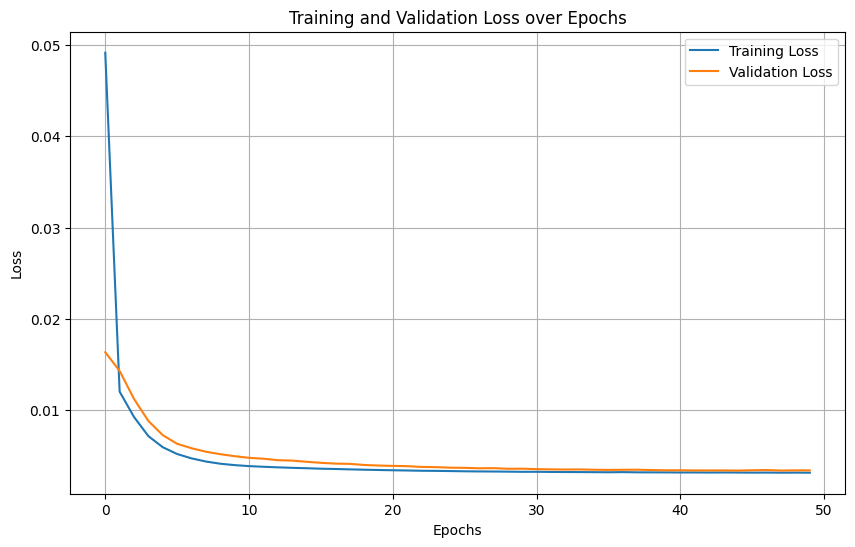

In [12]:
plot_loss(history_e1d1)

In [13]:
y_test.shape

(1784, 1, 12)

In [14]:
y_pred = model_e1d1.predict(X_test)

# Calculate MAE
test_mae = mean_absolute_error(y_test.reshape((y_test.shape[0], y_test.shape[2])), y_pred.reshape((y_pred.shape[0], y_pred.shape[2])))

print(f'MAE: {test_mae}')

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 0.055963947457211165


In [18]:
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [32]:
# Test predictions with an array from the original scale
input_vals = np.array([0.5,921,1.9,575,95,956,58,1143,672,13.7,67.8,1.0575])
input_vals = input_vals.reshape(1, -1)
rh = input_vals[:, 10].reshape(-1, 1) 
input_vals = scaler.transform(input_vals[:, [i for i in range(input_vals.shape[1]) if i != 10]])
input_vals = np.insert(input_vals, 10, rh/100, axis=1)
print(input_vals)

input_arr = input_vals.reshape((1, 1, 12))

y_pred = model_e1d1.predict(input_arr)
y_pred

[[0.06349206 0.23431734 0.04923077 0.1354946  0.10839161 0.48840927
  0.2248996  0.28753316 0.20551378 0.33548387 0.678      0.42652592]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[[0.11444517, 0.2697323 , 0.09361175, 0.21906859, 0.15135211,
         0.46281436, 0.25075078, 0.3185085 , 0.24074505, 0.31070372,
         0.66302335, 0.42798862]]], dtype=float32)

In [33]:
y_pred = y_pred.reshape(-1, N_FEATURES)
# scale features except rh
input_to_invert = y_pred[:, [i for i in range(y_pred.shape[1]) if i != 10]]
print(input_to_invert.shape)
outputs = scaler.inverse_transform(input_to_invert)
print(outputs)
outputs = np.insert(outputs, 10, y_pred[:, 10], axis=1)

for feature, val in zip(df.columns, outputs.reshape(N_FEATURES)):
    print(f"{feature}: {val}")

(1, 11)
[[8.2100463e-01 9.5938983e+02 3.3423817e+00 6.7553949e+02 1.3186011e+02
  9.2398077e+02 6.4436951e+01 1.2013885e+03 7.4228638e+02 1.2547724e+01
  1.0604931e+00]]
co_gt: 0.8210046291351318
s1_co: 959.3898315429688
c6h6_gt: 3.342381715774536
s2_nhmc: 675.5394897460938
nox_gt: 131.860107421875
s3_nox: 923.9807739257812
no2_gt: 64.43695068359375
s4_no2: 1201.3885498046875
s5_o3: 742.286376953125
temp: 12.547723770141602
rh: 0.6630233526229858
ah: 1.0604931116104126
